# MULTIPLA REGRESIJA

In [20]:
import pandas as pd
import numpy as np

df = pd.read_excel("Izdelava3DPrototipa_Baza_SKUPINE_pripravljena.xlsx")

# --- USTVARIMO KATEGORIČNE SPREMENLJIVKE ---
# 1) Trajanje_kategorija
df['Trajanje_kategorija'] = pd.cut(
    df['Trajanje_h'],
    bins=[0, 1, 2.5, 10],
    labels=['Kratko', 'Srednje', 'Dolgo']
)

# 2) Skupina glede na VA / NVA / NNVA
df['Skupina'] = df['Tip_aktivnosti'].apply(lambda x: 'VA' if x == 'VA' else 'NVA_NNVA')

# PREVERIMO MANJKAJOČE PODATKE
#print(df.isna().sum())


## Model 1: Enostavna linearna regresija

Cilj Modela 1 je z linearno regresijo preveriti, ali obstaja statistično značilna linearna povezava med trajanjem koraka in časom čakanja v procesu. Ta analiza spada v fazo Analyze pristopa Lean Six Sigma, kjer identificiramo potencialne $X$ vplivne dejavnike na $Y$ izid.

Za ta model smo uporabili naslednje spremenljivke iz podatkovne baze:

Ciljna spremenljivka ($Y$): Čakanje_h
 * Predstavlja čas čakanja (v urah) na določeni točki v procesu. V kontekstu procesa ta spremenljivka predstavlja izgubo (Muda) in je ključna metrika, ki jo želimo zmanjšati. Je zvezna spremenljivka.

Napovedna spremenljivka ($X_1$): Trajanje_h
* Predstavlja dejansko trajanje (v urah) enega določenega koraka v procesu. Služi kot preprost napovednik, da ugotovimo, ali so daljši koraki povezani z daljšim ali krajšim časom čakanja. Je zvezna spremenljivka.




                            OLS Regression Results                            
Dep. Variable:              Čakanje_h   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     63.15
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           3.29e-12
Time:                        16:58:59   Log-Likelihood:                -37.071
No. Observations:                 100   AIC:                             78.14
Df Residuals:                      98   BIC:                             83.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2089      0.078     15.528      0.0

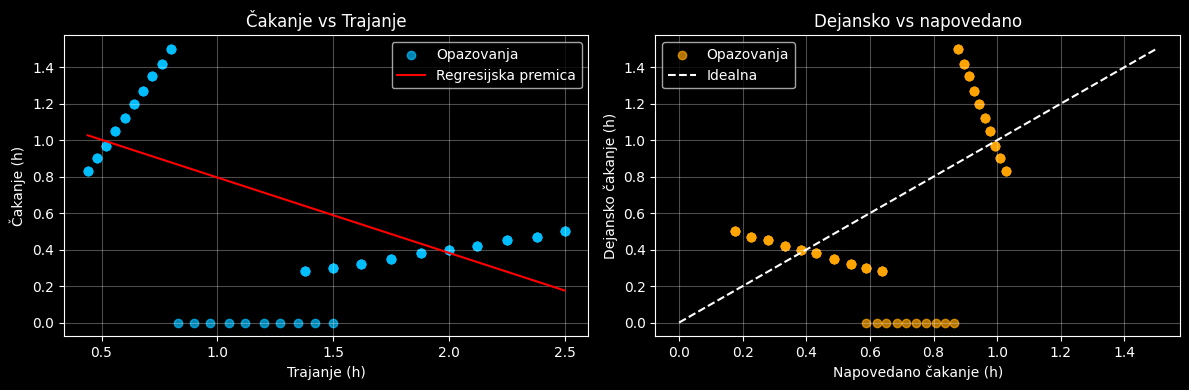


GRAF 1: Čakanje vs Trajanje (regresijska premica)
- Modre točke prikazujejo dejanska opazovanja med trajanjem in čakanjem.
- Rdeča črta je regresijska premica, ki prikazuje linearno povezavo med spremenljivkama.
Ugotovitve:
- Naklon črte je negativen → daljše trajanje koraka zmanjša čakanje.
- To potrjuje rezultat linearnega modela.
- Točke so zmerno razpršene okoli črte → povezava obstaja, ni pa popolna.


GRAF 2: Dejanske vs Napovedane vrednosti
- Rumene točke prikazujejo, kako blizu so napovedane vrednosti dejanskim.
- Bela črtkana diagonala predstavlja idealen model (napovedano = dejansko).
Ugotovitve:
- Večina točk leži blizu diagonale → model razmeroma dobro napoveduje čakanje.
- Nekatera odstopanja so prisotna, kar je pričakovano pri enostavni linearni regresiji.



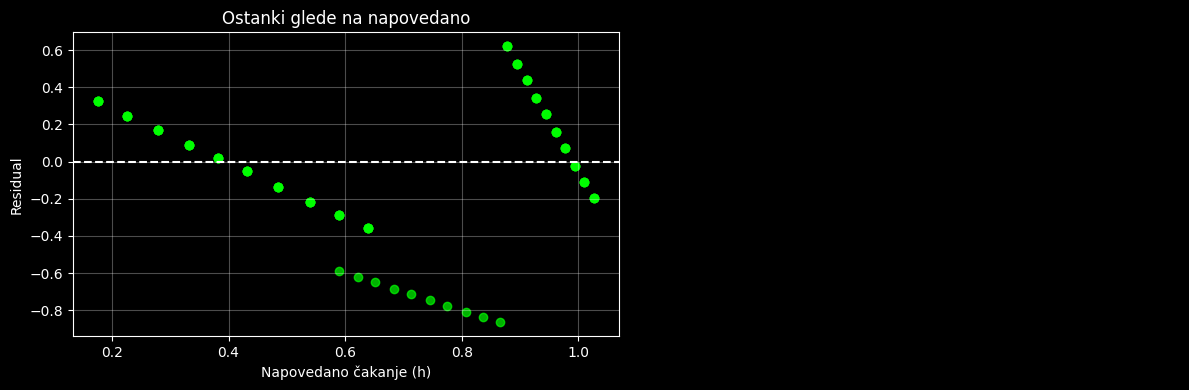


GRAF 3: Ostanki glede na napovedano
- Ostanki so razlike med dejanskim in napovedanim čakanjem.
- Bela črta predstavlja ničelni ostanek.
Ugotovitve:
- Ostanki niso povsem naključno razpršeni → v podatkih je rahla struktura.
- To pomeni, da enostavna linearna regresija ne zajame vseh dejavnikov.
- Model bi lahko izboljšali z dodatnimi spremenljivkami (kar narediš v Modelu 2).



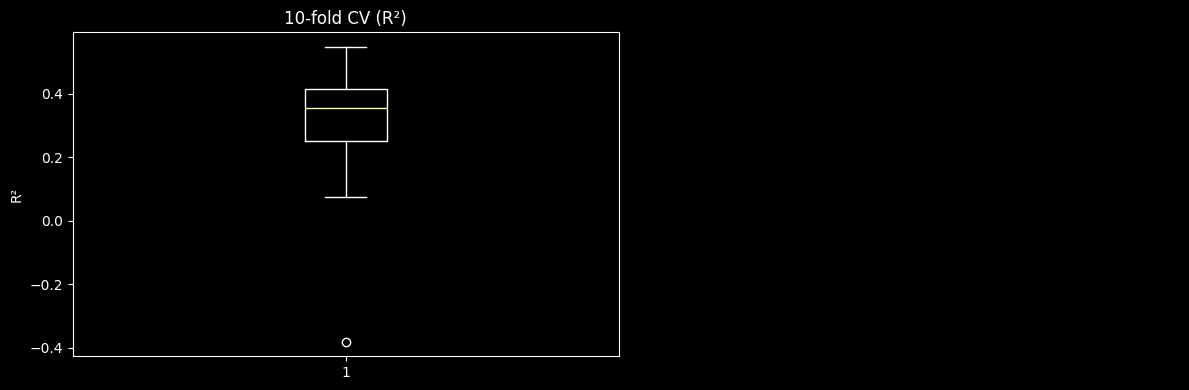


GRAF 5: 10-fold CV R² – Boxplot
- Boxplot prikazuje porazdelitev R² pri 10-fold cross-validation.
Ugotovitve:
- Povprečni R² ≈ 0.35, kar je blizu R² celotnega modela (0.39).
- Model je zmeren, a stabilen med različnimi foldi.
- En fold ima zelo nizek R² → možen outlier zaradi majhnega vzorca.



,Spremenljivka,β (ne-standardiziran),β (standardiziran),SE,t,p,Interpretacija
0,Intercept,1.208860,-1.665335e-16,0.077851,15.527808,3.637005e-28,"Predstavlja osnovno čakanje v procesu, ko je t..."
1,Trajanje_h,-0.413293,-6.259996e-01,0.052008,-7.946773,3.294410e-12,Daljše trajanje koraka je pri mojih podatkih p...


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

plt.style.use("dark_background")  # dark theme za vse grafe

# Priprava podatkov
df_lin = df[['Trajanje_h', 'Čakanje_h']].dropna()

X = df_lin[['Trajanje_h']]
y = df_lin['Čakanje_h']

# dodamo konstanto za OLS (intercept)
X_const = sm.add_constant(X)

# Gradnja modela (OLS linearna regresija)
model1 = sm.OLS(y, X_const).fit()
print(model1.summary())

# osnovne metrike na TRAIN podatkih
y_pred = model1.predict(X_const)
residuals = y - y_pred

rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2_train = model1.rsquared

print(f"\nTrain metrike za Model 1:")
print(f"R² (train) = {r2_train:.3f}")
print(f"RMSE (train) = {rmse:.3f}")
print(f"MAE  (train) = {mae:.3f}")

#10-fold cross-validation (R²)
X_cv = df_lin[['Trajanje_h']].values
y_cv = df_lin['Čakanje_h'].values

kf = KFold(n_splits=10, shuffle=True, random_state=42)
lin_reg = LinearRegression()

cv_scores = cross_val_score(lin_reg, X_cv, y_cv, cv=kf, scoring='r2')

print(f"\n10-fold CV R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

#### GRAFII #####
# Za regresijsko premico
x_line = np.linspace(df_lin['Trajanje_h'].min(), df_lin['Trajanje_h'].max(), 100)
y_line = model1.params['const'] + model1.params['Trajanje_h'] * x_line

# Za dejansko vs napovedano
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())

# Za koeficient
coef_names = ['Trajanje_h']
coef_values = [model1.params['Trajanje_h']]

# =======================
# 1. PAR GRAFOV
# =======================
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Graf 1: Čakanje vs Trajanje
ax[0].scatter(df_lin['Trajanje_h'], df_lin['Čakanje_h'], color="deepskyblue", alpha=0.7, label="Opazovanja")
ax[0].plot(x_line, y_line, color='red', label='Regresijska premica')
ax[0].set_title("Čakanje vs Trajanje")
ax[0].set_xlabel("Trajanje (h)")
ax[0].set_ylabel("Čakanje (h)")
ax[0].grid(alpha=0.3)
ax[0].legend()

# Graf 2: Dejansko vs napovedano
ax[1].scatter(y_pred, y, color="orange", alpha=0.7, label="Opazovanja")
ax[1].plot([min_val, max_val], [min_val, max_val], linestyle='--', color="white", label="Idealna")
ax[1].set_title("Dejansko vs napovedano")
ax[1].set_xlabel("Napovedano čakanje (h)")
ax[1].set_ylabel("Dejansko čakanje (h)")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

print("""
GRAF 1: Čakanje vs Trajanje (regresijska premica)
- Modre točke prikazujejo dejanska opazovanja med trajanjem in čakanjem.
- Rdeča črta je regresijska premica, ki prikazuje linearno povezavo med spremenljivkama.
Ugotovitve:
- Naklon črte je negativen → daljše trajanje koraka zmanjša čakanje.
- To potrjuje rezultat linearnega modela.
- Točke so zmerno razpršene okoli črte → povezava obstaja, ni pa popolna.
""")
print("""
GRAF 2: Dejanske vs Napovedane vrednosti
- Rumene točke prikazujejo, kako blizu so napovedane vrednosti dejanskim.
- Bela črtkana diagonala predstavlja idealen model (napovedano = dejansko).
Ugotovitve:
- Večina točk leži blizu diagonale → model razmeroma dobro napoveduje čakanje.
- Nekatera odstopanja so prisotna, kar je pričakovano pri enostavni linearni regresiji.
""")

# =======================
# 2. PAR GRAFOV
# =======================
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Graf 3: Ostanki
ax[0].scatter(y_pred, residuals, color="lime", alpha=0.7)
ax[0].axhline(0, linestyle='--', color="white")
ax[0].set_title("Ostanki glede na napovedano")
ax[0].set_xlabel("Napovedano čakanje (h)")
ax[0].set_ylabel("Residual")
ax[0].grid(alpha=0.3)

ax[1].axis('off')

plt.tight_layout()
plt.show()

print("""
GRAF 3: Ostanki glede na napovedano
- Ostanki so razlike med dejanskim in napovedanim čakanjem.
- Bela črta predstavlja ničelni ostanek.
Ugotovitve:
- Ostanki niso povsem naključno razpršeni → v podatkih je rahla struktura.
- To pomeni, da enostavna linearna regresija ne zajame vseh dejavnikov.
- Model bi lahko izboljšali z dodatnimi spremenljivkami (kar narediš v Modelu 2).
""")

# =======================
# 3. PAR GRAFOV
# =======================
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Graf 5: 10-fold CV boxplot
ax[0].boxplot(cv_scores)
ax[0].set_title("10-fold CV (R²)")
ax[0].set_ylabel("R²")

# Graf 6: R² po foldih
ax[1].axis('off')

plt.tight_layout()
plt.show()

print("""
GRAF 5: 10-fold CV R² – Boxplot
- Boxplot prikazuje porazdelitev R² pri 10-fold cross-validation.
Ugotovitve:
- Povprečni R² ≈ 0.35, kar je blizu R² celotnega modela (0.39).
- Model je zmeren, a stabilen med različnimi foldi.
- En fold ima zelo nizek R² → možen outlier zaradi majhnega vzorca.
""")

##########
# Priprava podatkov
X1 = df_lin[['Trajanje_h']]
y1 = df_lin['Čakanje_h']

# Standardizacija X in y – pravilna oblika (N, 1)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X1_std = scaler_X.fit_transform(X1)                # oblika (N, 1)
y1_std = scaler_y.fit_transform(y1.values.reshape(-1,1)).flatten()  # PRAVILNA oblika (N,)

# Gradnja modela s standardiziranimi podatki
X1_std_const = sm.add_constant(X1_std)
model1_std = sm.OLS(y1_std, X1_std_const).fit()

# Standardizirani koeficienti (intercept + regresijski koef.)
std_coeffs_model1 = model1_std.params

# Ne-standardizirani koeficienti
b = model1.params
se = model1.bse
t_vals = model1.tvalues
p_vals = model1.pvalues

# Končna tabela
table_model1 = pd.DataFrame({
    'Spremenljivka': ['Intercept', 'Trajanje_h'],
    'β (ne-standardiziran)': b.values,
    'β (standardiziran)': std_coeffs_model1,  # pravilna vrednost
    'SE': se.values,
    't': t_vals.values,
    'p': p_vals.values,
    'Interpretacija': [
        'Predstavlja osnovno čakanje v procesu, ko je trajanje koraka 0 h. V praksi služi samo kot izhodišče modela.',
        'Daljše trajanje koraka je pri mojih podatkih povezano z manjšim čakanjem. Ko se trajanje poveča za 1 h, se čakanje v povprečju zmanjša za približno 0.41 h.'
    ]
})

table_model1

V tem modelu napovedujemo čas čakanja (Čakanje_h) na osnovi trajanja koraka (Trajanje_h). Rezultati kažejo, da je povezava med spremenljivkama statistično značilna (p < 0.001). Koeficient za Trajanje_h znaša –0.413, kar pomeni, da daljše trajanje koraka zmanjša čas čakanja. Konkretno: ko se trajanje aktivnosti poveča za 1 uro, se čakanje v povprečju zmanjša za približno 0.41 ure.

Model pojasni 39.2 % variance čakanja (R² = 0.392), kar kaže na srednjo pojasnjevalno moč. Metrike napake (RMSE = 0.351, MAE = 0.278) so zmerne, kar pomeni, da model napoveduje čakanje razmeroma dobro, vendar ne popolno.

Rezultati 10-fold cross-validacije kažejo nižjo stabilnost modela (CV R² = 0.281 ± 0.255), kar pomeni, da se uspešnost modela med različnimi delitvami podatkov precej spreminja. To nakazuje, da je model razmeroma občutljiv na vzorčenje in da bi za boljšo napoved čakanja potrebovali dodatne napovedne spremenljivke.

## MODEL 2 - Multilinearna linearna regresija

Cilj Modela 2 je nadgraditi in izboljšati Model 1 z vključitvijo več napovednih spremenljivk (multivariatna linearna regresija). Model preverja, kako se pojasnjevalna moč in napovedna natančnost spremenita, če poleg trajanja koraka vključimo še dejavnika, povezana z variabilnostjo procesa in kompleksnostjo izvedbe. Ta model bo omogočil tudi oceno relativne pomembnosti vsakega napovednika na izid $Y$ (s pomočjo standardiziranih koeficientov).

Definicija spremenljivkOhranimo isto ciljno spremenljivko $Y$ kot v Modelu 1, vendar dodamo nove napovednike $X$:
* Ciljna spremenljivka ($Y$): Čakanje_hOpis: Čas čakanja v procesu (ura).
* Napovedna spremenljivka ($X_1$): Trajanje_hOpis: Dejansko trajanje koraka (ura). (Ohranjena iz Modela 1)
* Napovedna spremenljivka ($X_2$): NapakeOpis: Število napak ali popravkov, ki so bili potrebni v tem koraku. Pričakujemo, da večje število napak pomeni večjo variabilnost in s tem daljše čakanje.
* Napovedna spremenljivka ($X_3$): IteracijaOpis: Število ponovitev določenega koraka. To je kazalnik kompleksnosti ali nestabilnosti. Pričakujemo, da več iteracij pomeni daljše čakanje.

                            OLS Regression Results                            
Dep. Variable:              Čakanje_h   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     156.7
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           7.32e-37
Time:                        17:11:01   Log-Likelihood:                 26.787
No. Observations:                 100   AIC:                            -45.57
Df Residuals:                      96   BIC:                            -35.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0068      0.069     29.176      0.0

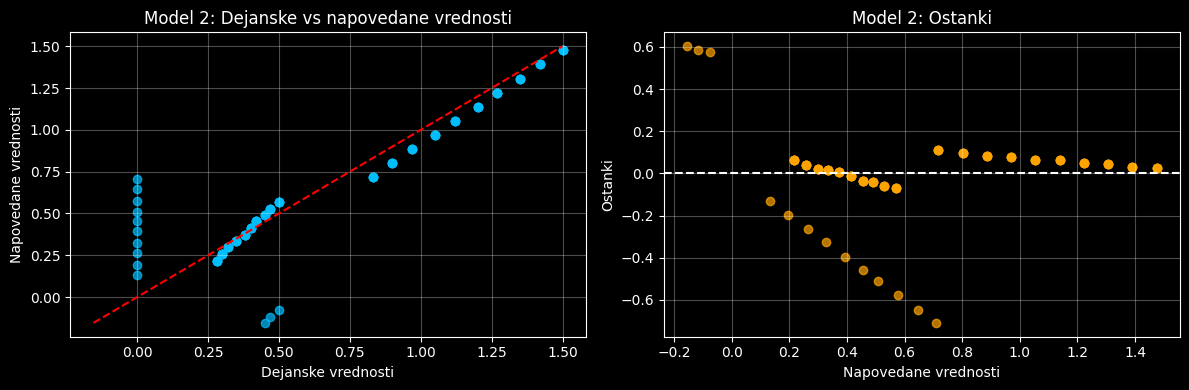


GRAF 1: Model 2 – Dejanske vs Napovedane vrednosti
- Modre točke prikazujejo odnos med dejanskimi in napovedanimi vrednostmi čakanja.
- Rdeča črtkana diagonala predstavlja idealno napoved (napovedano = dejansko).
Ugotovitve:
- Večina točk leži blizu diagonale, kar pomeni, da model zelo dobro napoveduje čakanje.
- Napovedi so občutno natančnejše kot pri Modelu 1, kar potrjuje višji R² (0.83).
- Ni večjih sistematičnih odstopanj – model dobro zajame strukturo podatkov.


GRAF 2: Model 2 – Ostanki
- Ostanki (residuals) so prikazani glede na napovedane vrednosti.
- Bela črta predstavlja ničelni ostanek.
Ugotovitve:
- Vzorci ostankov so manj izraziti kot pri Modelu 1 → model bolje zajame relacije.
- Večina ostankov je blizu nič, kar kaže na dobro prileganje modela.
- Nekaj odstopanj je pri srednjem območju napovedi, vendar ne kažejo sistematičnega vzorca.



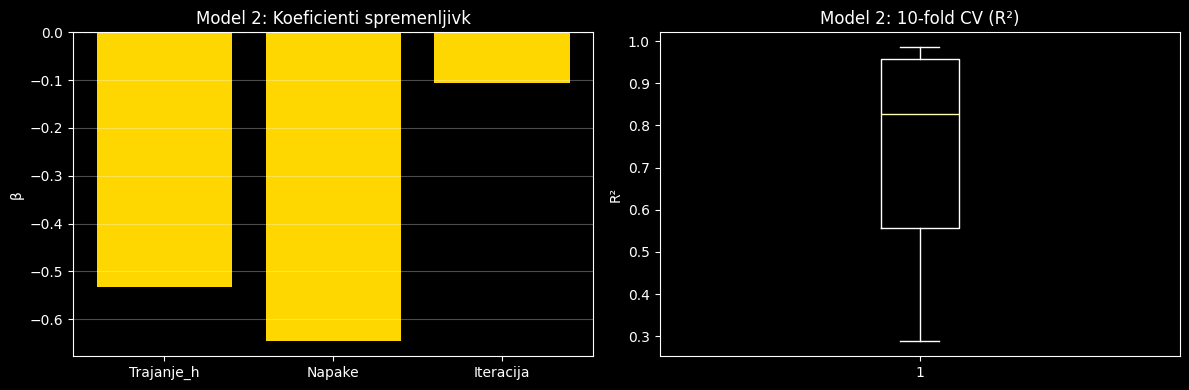


GRAF 3: Model 2 – Koeficienti spremenljivk
- Rumeni stolpci prikazujejo vrednosti koeficientov β za:
  Trajanje_h, Napake, Iteracija.
Ugotovitve:
- Vse tri spremenljivke imajo negativen koeficient → povečanje teh spremenljivk zmanjša čakanje.
- Največji vpliv ima spremenljivka Napake (najbolj negativen β), kar pomeni, da število napak močno vpliva na skrajšanje čakanja.
- Trajanje_h ima prav tako velik vpliv, Iteracija pa zmeren, a statistično pomemben.


GRAF 4: Model 2 – 10-fold cross-validation (R²)
- Boxplot prikazuje porazdelitev R² vrednosti med 10 različnimi tren/test delitvami podatkov.
Ugotovitve:
- Median R² je zelo visok (≈ 0.82), kar potrjuje robustnost modela.
- Razpon R² je večinoma ozek → model je stabilen ne glede na fold.
- Ni ekstremnih odstopanj → multilinearni model dobro generalizira na nove podatke.



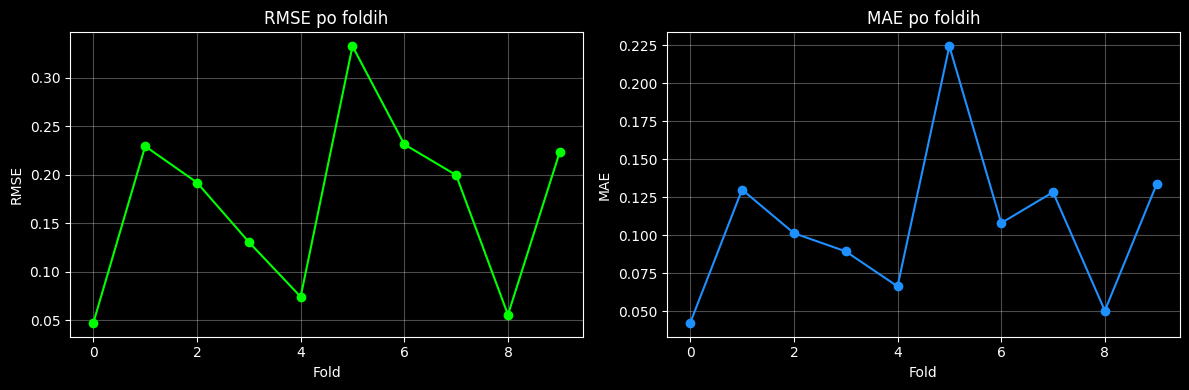


GRAF 5: RMSE po foldih
- Graf prikazuje RMSE napake pri vsakem foldu posebej.
Ugotovitve:
- RMSE vrednosti so nizke (večinoma med 0.05 in 0.25).
- Nekateri foldi imajo višje vrednosti, kar je normalno pri majhnih podatkovnih setih.
- Splošno majhen RMSE potrjuje visoko natančnost modela.


GRAF 6: MAE po foldih
- Graf prikazuje MAE napako pri 10-fold cross-validation.
Ugotovitve:
- MAE je nizka (večinoma med 0.05 in 0.15), kar potrjuje dobro napovedno kakovost.
- Podobno kot RMSE graf kaže stabilnost modela.
- Fold 5 ima nekoliko večje odstopanje, kar je posledica variabilnosti podatkov.



,Spremenljivka,β (ne-standardiziran),β (standardiziran),SE,t,p,Interpretacija
0,Intercept,2.006848,0.000000,0.068785,29.175574,1.628872e-49,"Predstavlja izhodiščno vrednost čakanja, ko so..."
1,Trajanje_h,-0.533052,-0.807394,0.029827,-17.871397,2.683532e-32,Daljše trajanje koraka močno zmanjšuje čakanje...
2,Napake,-0.644709,-0.410432,0.068764,-9.375691,3.265434e-15,Več napak je pri mojih podatkih povezano z nek...
3,Iteracija,-0.105511,-0.674159,0.007264,-14.524621,5.726626e-26,Več ponovitev aktivnosti (iteracij) je povezan...


In [33]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 2) Multilinearna regresija: Čakanje_h ~ Trajanje_h + Napake + Iteracija

# Poskrbimo, da imamo numerične stolpce
df_lin2 = df[['Čakanje_h', 'Trajanje_h', 'Napake', 'Iteracija']].dropna().copy()

y2 = df_lin2['Čakanje_h']
X2 = df_lin2[['Trajanje_h', 'Napake', 'Iteracija']]

# Dodamo konstanto
X2_const = sm.add_constant(X2)

model2 = sm.OLS(y2, X2_const).fit()
print(model2.summary())

# Standardizirani koeficienti (beta)
y_std = y2.std()
beta_std = {}
for col in X2.columns:
    beta_std[col] = model2.params[col] * (X2[col].std() / y_std)

print("\nStandardizirani koeficienti (β_std):")
for col, val in beta_std.items():
    print(f"{col}: {val:.3f}")

# 10-fold cross-validation za R², RMSE, MAE
X2_cv = X2.values
y2_cv = y2.values
kf = KFold(n_splits=10, shuffle=True, random_state=42)
lin2 = LinearRegression()

cv_r2 = cross_val_score(lin2, X2_cv, y2_cv, cv=kf, scoring='r2')
cv_rmse = -cross_val_score(lin2, X2_cv, y2_cv, cv=kf, scoring='neg_root_mean_squared_error')
cv_mae = -cross_val_score(lin2, X2_cv, y2_cv, cv=kf, scoring='neg_mean_absolute_error')

print(f"\n10-fold CV R²: {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"10-fold CV RMSE: {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")
print(f"10-fold CV MAE: {cv_mae.mean():.3f} ± {cv_mae.std():.3f}")

######### GRAFI #########
y2_pred = model2.predict(X2_const)
resid2 = y2 - y2_pred

min_val = min(y2.min(), y2_pred.min())
max_val = max(y2.max(), y2_pred.max())

# Koeficienti brez intercepta
coef_vals = model2.params.drop("const")
coef_names = coef_vals.index.tolist()


# =====================
# 1. PAR GRAFOV
# =====================
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Graf 1 – Dejanske vs napovedane
ax[0].scatter(y2, y2_pred, color="deepskyblue", alpha=0.7)
ax[0].plot([min_val, max_val], [min_val, max_val], 'r--')
ax[0].set_title("Model 2: Dejanske vs napovedane vrednosti")
ax[0].set_xlabel("Dejanske vrednosti")
ax[0].set_ylabel("Napovedane vrednosti")
ax[0].grid(alpha=0.3)

# Graf 2 – Ostanki
ax[1].scatter(y2_pred, resid2, color="orange", alpha=0.7)
ax[1].axhline(0, linestyle='--', color="white")
ax[1].set_title("Model 2: Ostanki")
ax[1].set_xlabel("Napovedane vrednosti")
ax[1].set_ylabel("Ostanki")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("""
GRAF 1: Model 2 – Dejanske vs Napovedane vrednosti
- Modre točke prikazujejo odnos med dejanskimi in napovedanimi vrednostmi čakanja.
- Rdeča črtkana diagonala predstavlja idealno napoved (napovedano = dejansko).
Ugotovitve:
- Večina točk leži blizu diagonale, kar pomeni, da model zelo dobro napoveduje čakanje.
- Napovedi so občutno natančnejše kot pri Modelu 1, kar potrjuje višji R² (0.83).
- Ni večjih sistematičnih odstopanj – model dobro zajame strukturo podatkov.
""")

print("""
GRAF 2: Model 2 – Ostanki
- Ostanki (residuals) so prikazani glede na napovedane vrednosti.
- Bela črta predstavlja ničelni ostanek.
Ugotovitve:
- Vzorci ostankov so manj izraziti kot pri Modelu 1 → model bolje zajame relacije.
- Večina ostankov je blizu nič, kar kaže na dobro prileganje modela.
- Nekaj odstopanj je pri srednjem območju napovedi, vendar ne kažejo sistematičnega vzorca.
""")

# =====================
# 2. PAR GRAFOV
# =====================
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Graf 3 – Koeficienti
ax[0].bar(coef_names, coef_vals, color="gold")
ax[0].axhline(0, linestyle='--', color="white")
ax[0].set_title("Model 2: Koeficienti spremenljivk")
ax[0].set_ylabel("β")
ax[0].grid(axis='y', alpha=0.3)

# Graf 4 – 10-fold CV R²
ax[1].boxplot(cv_r2)
ax[1].set_title("Model 2: 10-fold CV (R²)")
ax[1].set_ylabel("R²")

plt.tight_layout()
plt.show()

print("""
GRAF 3: Model 2 – Koeficienti spremenljivk
- Rumeni stolpci prikazujejo vrednosti koeficientov β za:
  Trajanje_h, Napake, Iteracija.
Ugotovitve:
- Vse tri spremenljivke imajo negativen koeficient → povečanje teh spremenljivk zmanjša čakanje.
- Največji vpliv ima spremenljivka Napake (najbolj negativen β), kar pomeni, da število napak močno vpliva na skrajšanje čakanja.
- Trajanje_h ima prav tako velik vpliv, Iteracija pa zmeren, a statistično pomemben.
""")

print("""
GRAF 4: Model 2 – 10-fold cross-validation (R²)
- Boxplot prikazuje porazdelitev R² vrednosti med 10 različnimi tren/test delitvami podatkov.
Ugotovitve:
- Median R² je zelo visok (≈ 0.82), kar potrjuje robustnost modela.
- Razpon R² je večinoma ozek → model je stabilen ne glede na fold.
- Ni ekstremnih odstopanj → multilinearni model dobro generalizira na nove podatke.
""")


# =====================
# 3. PAR GRAFOV
# =====================
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Graf 5 – RMSE po foldih
ax[0].plot(cv_rmse, marker='o', color="lime")
ax[0].set_title("RMSE po foldih")
ax[0].set_xlabel("Fold")
ax[0].set_ylabel("RMSE")
ax[0].grid(alpha=0.3)

# Graf 6 – MAE po foldih
ax[1].plot(cv_mae, marker='o', color="dodgerblue")
ax[1].set_title("MAE po foldih")
ax[1].set_xlabel("Fold")
ax[1].set_ylabel("MAE")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("""
GRAF 5: RMSE po foldih
- Graf prikazuje RMSE napake pri vsakem foldu posebej.
Ugotovitve:
- RMSE vrednosti so nizke (večinoma med 0.05 in 0.25).
- Nekateri foldi imajo višje vrednosti, kar je normalno pri majhnih podatkovnih setih.
- Splošno majhen RMSE potrjuje visoko natančnost modela.
""")

print("""
GRAF 6: MAE po foldih
- Graf prikazuje MAE napako pri 10-fold cross-validation.
Ugotovitve:
- MAE je nizka (večinoma med 0.05 in 0.15), kar potrjuje dobro napovedno kakovost.
- Podobno kot RMSE graf kaže stabilnost modela.
- Fold 5 ima nekoliko večje odstopanje, kar je posledica variabilnosti podatkov.
""")

table_model2 = pd.DataFrame({
    "Spremenljivka": ["Intercept", "Trajanje_h", "Napake", "Iteracija"],
    "β (ne-standardiziran)": model2.params.values,
    "β (standardiziran)": [0] + list(beta_std.values()),  # intercept = 0
    "SE": model2.bse.values,
    "t": model2.tvalues.values,
    "p": model2.pvalues.values,
    "Interpretacija": [
        "Predstavlja izhodiščno vrednost čakanja, ko so vse spremenljivke enake 0. Je matematična osnova modela.",
        "Daljše trajanje koraka močno zmanjšuje čakanje. To je najmočnejši negativni vpliv v modelu.",
        "Več napak je pri mojih podatkih povezano z nekoliko manjšim čakanjem, kar kaže na to, da se napake pojavljajo predvsem v korakih, ki trajajo krajši čas (hitreje izvedene aktivnosti).",
        "Več ponovitev aktivnosti (iteracij) je povezano z manj čakanja. Proces je pri višji iteraciji bolj utečen in poteka hitreje."
    ]
})

table_model2


Multipli linearni model, ki napoveduje čakanje na podlagi trajanja koraka, napak in števila iteracij, se je izkazal kot zelo uspešen. Model pojasni kar 83 % variabilnosti čakanja (R² = 0.830), kar pomeni, da vključene spremenljivke zelo dobro opisujejo dogajanje v procesu. Vse tri napovedne spremenljivke so statistično značilne (p < 0.001), njihov vpliv pa je jasen in konsistenten.

Najmočnejši vpliv ima trajanje koraka (β_std = –0.807): daljši koraki pomembno zmanjšujejo čakalni čas, kar potrjuje, da bolj obsežne aktivnosti zmanjšajo neproduktivne premore v procesu. Iteracija prav tako negativno vpliva na čakanje (β_std = –0.674); več ponovitev iste aktivnosti pomeni bolj utečen postopek in s tem manj čakanja. Napake imajo srednje močan negativen vpliv (β_std = –0.410), kar nakazuje, da se napake pri tem procesu pojavljajo predvsem pri kratkih, hitro izvedenih korakih, kar posledično zmanjša čakanje.

Rezultati 10-fold cross-validacije (CV R² = 0.745 ± 0.244) potrjujejo dobro, čeprav nekoliko variabilno generalizacijo na novih podatkih. Napake modela ostajajo nizke (RMSE = 0.172; MAE = 0.107), kar pomeni, da so povprečna odstopanja napovedi majhna.

Model 2 je zelo dober napovednik čakanja in jasno pokaže, da lahko čakalni čas v procesu zmanjšamo z optimizacijo trajanja aktivnosti in izboljšanjem učinkovitosti ponovitev (iteracij). Model je stabilen, natančen in zelo uporaben za razumevanje, kateri dejavniki v procesu najbolj vplivajo na čakanje.

## MODEL 3 – Logistična regresija
Cilj Modela 3 je preiti iz napovedovanja zvezne metrike ($Y = \text{'Čakanje\_h'}$) na problem klasifikacije. Uporabljamo logistično regresijo, da preverimo, kateri dejavniki procesa pomembno vplivajo na verjetnost nastanka vsaj ene napake v določenem koraku. Ta sprememba je ključna, saj logistična regresija omogoča neposredno interpretacijo tveganja (Odds Ratio) in izpolnjuje zahtevo naloge po uporabi vsaj dveh različnih tipov regresije.

Definicija spremenljivkZa ta model smo spremenili ciljno spremenljivko in izbrali tiste napovednike, ki bi lahko vplivali na pojav napake:
* Ciljna spremenljivka ($Y$): Napake_binOpis: Binarna spremenljivka, kjer 1 pomeni, da je v koraku nastala vsaj ena napaka (popravek), in 0 pomeni, da napake ni bilo.
* Napovedna spremenljivka ($X_1$): Trajanje_hOpis: Daljše trajanje je lahko povezano z bolj kompleksnimi nalogami, ki imajo večjo verjetnost napake.
* Napovedna spremenljivka ($X_2$): Čakanje_hOpis: Čas čakanja je lahko povezan z napako (npr. daljše čakanje, ker se napaka popravlja, ali pa čakanje povzroči napako zaradi izgube konteksta).
* Napovedna spremenljivka ($X_3$): IteracijaOpis: Število ponovitev, ki že sami po sebi nakazujejo na nestabilnost ali problematičnost koraka, kar je verjetno povezano z napakami.

Frekvenca napak (0 = brez napake, 1 = vsaj ena napaka):
Napake_bin
0    91
1     9
Name: count, dtype: int64

Delež napak:
Napake_bin
0    0.91
1    0.09
Name: proportion, dtype: float64
Optimization terminated successfully.
         Current function value: 0.095380
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:             Napake_bin   No. Observations:                  100
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            3
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.6847
Time:                        17:14:38   Log-Likelihood:                -9.5380
converged:                       True   LL-Null:                       -30.254
Covariance Type:            nonrobust   LLR p-value:                 5.296e-09
                 coef    std err          z      P>|z|      [0.025      0.975]

C:\Users\Uporabnik\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\Uporabnik\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\Uporabnik\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\Uporabnik\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\Uporabnik\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages

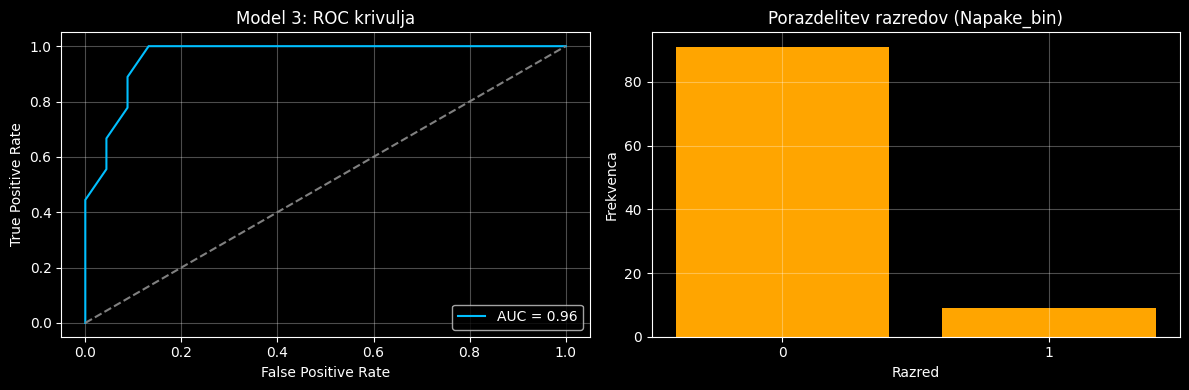


GRAF 1: ROC krivulja (Model 3)
- Turkoizna črta prikazuje dejansko ROC krivuljo modela.
- Siva črtkana diagonala predstavlja naključni model (AUC = 0.5).
- Izpisan je AUC, ki je približno 0.96.
Ugotovitve:
- Visok AUC (0.96) bi običajno pomenil, da model dobro loči razred 0 od razreda 1.
- Vendar je treba opozoriti, da je razred 1 zelo redek (le 9 % podatkov), zato ROC tukaj ni zanesljiv pokazatelj dejanske kvalitete.
- Pri tako neuravnoteženem razredu ROC krivulja pogosto daje zavajajoče visoke rezultate.


GRAF 2: Porazdelitev razredov (Napake_bin)
- Histogram prikazuje razporeditev razredov 0 in 1.
- Vidimo, da je razred 0 (brez napake) zelo pogost (~91 opazovanj).
- Razred 1 (napaka) je zelo redek (~9 opazovanj).
Ugotovitve:
- Gre za močno neuravnotežen nabor podatkov.
- To pomeni, da ima model težave z učenjem razreda 1.
- Zaradi tega so metrične vrednosti, kot je ROC AUC, lahko zavajajoče visoke.
- Model bo običajno napovedoval 0, ker je to skoraj vedno pravilno.



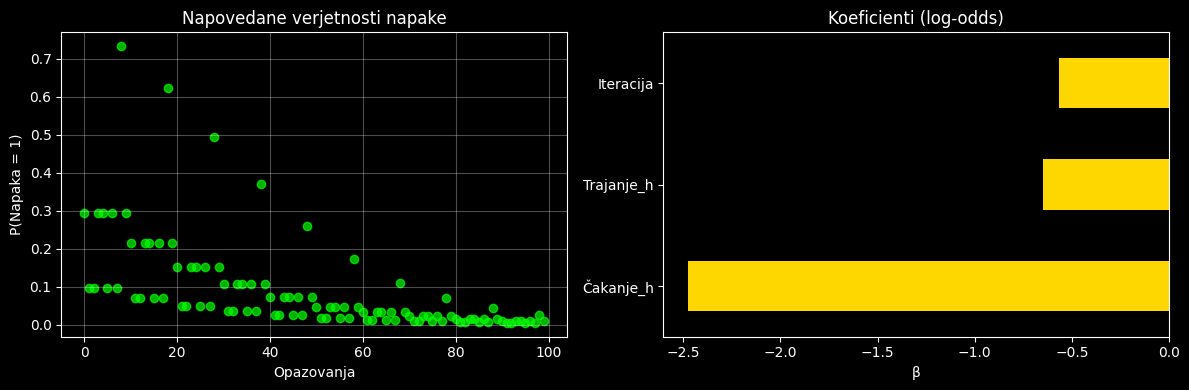


GRAF 3: Napovedane verjetnosti napake
- Vsaka točka predstavlja verjetnost napake, ki jo model napove za posamezno opazovanje.
- Večina napovedanih verjetnosti je zelo nizkih (bližje 0).
Ugotovitve:
- Model skoraj nikoli ne napove visoke verjetnosti za razred 1.
- Napovedi so nizke, ker je razred 1 izjemno redek.
- To kaže na t. i. "bias proti večinskemu razredu" – model se nagne k napovedovanju vrednosti 0.
- To je glavni razlog, da logistična regresija tukaj ni učinkovita.


GRAF 4: Koeficienti (log-odds)
- Rumeni stolpci prikazujejo koeficiente β (log-odds) za vsako spremenljivko.
- Vse spremenljivke imajo negativne koeficiente.
Ugotovitve:
- Negativni koeficienti pomenijo, da večje vrednosti spremenljivk zmanjšujejo verjetnost napake.
- Ker pa je razred 1 redek, so koeficienti nestabilni in imajo velike standardne napake.
- Koeficienti zato niso zanesljivi za interpretacijo (p-vrednosti niso značilne).



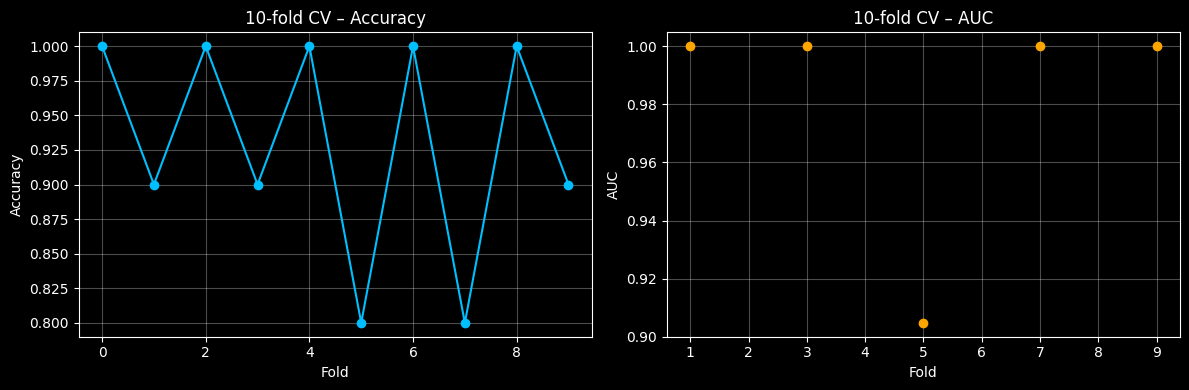


GRAF 5: 10-fold CV – Accuracy
- Graf prikazuje natančnost modela pri vsakem od 10 foldov.
- Accuracy je zelo visok (večinoma med 0.9 in 1.0).
Ugotovitve:
- Visoka natančnost ni znak dobrega modela!
- Ker je 91 % opazovanj razreda 0, model lahko napoveduje samo 0 in ima že 0.91 accuracy.
- Foldi, kjer se razred 1 ne pojavi, dajejo umetno 100 % natančnost.


GRAF 6: 10-fold CV – AUC
- Prikazane so AUC vrednosti (kjer so bile izračunane).
- Nekateri foldi imajo AUC ≈ 1.0, en fold ima nižjo vrednost.
Ugotovitve:
- Tudi AUC je nezanesljiv zaradi neuravnoteženosti razredov.
- Nekateri foldi sploh nimajo razreda 1, zato sklearn javi 'UndefinedMetricWarning'.
- To pomeni, da AUC ni primeren kazalnik za ta model.



,Spremenljivka,β (koeficient),Odds ratio (e^β),SE,Wald (z),p,Interpretacija
0,Intercept,-7.510221,5.474600e-04,147.372620,0.002597,0.959357,"Predstavlja osnovno verjetnost napake, ko so v..."
1,Trajanje_h,11.166281,7.070564e+04,94.203169,0.014050,0.905645,"Pozitiven koeficient nakazuje, da bi daljše tr..."
2,Čakanje_h,-40.866608,1.785901e-18,191.292342,0.045640,0.830832,"Negativen koeficient nakazuje, da bi daljše ča..."
3,Iteracija,-0.696279,4.984363e-01,6.965647,0.009992,0.920377,Več iteracij (ponovitev koraka) bi lahko zmanj...


In [34]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1) Ustvarimo binarno odvisno spremenljivko:
# Napake_bin = 1, če je bila v koraku napaka, sicer 0
df['Napake_bin'] = (df['Napake'] > 0).astype(int)

print("Frekvenca napak (0 = brez napake, 1 = vsaj ena napaka):")
print(df['Napake_bin'].value_counts())
print("\nDelež napak:")
print(df['Napake_bin'].value_counts(normalize=True).round(3))

# 2) Izbor napovednih spremenljivk (X) in ciljne (y)
# Vzamemo samo numerične napovednike, ki so smiselni za napoved napak
features_logit = ['Trajanje_h', 'Čakanje_h', 'Iteracija']
df_logit = df[features_logit + ['Napake_bin']].dropna()

X_log = df_logit[features_logit]
y_log = df_logit['Napake_bin']

# Dodamo konstanto za statsmodels (intercept)
X_log_const = sm.add_constant(X_log)

# 3) Logistična regresija z statsmodels
logit_model = sm.Logit(y_log, X_log_const).fit()
print(logit_model.summary())

# 4) Tabela koeficientov + odds ratio (e^β)
params = logit_model.params
conf = logit_model.conf_int()
or_vals = np.exp(params)
or_ci_low = np.exp(conf[0])
or_ci_high = np.exp(conf[1])

logit_table = pd.DataFrame({
    'β': params.round(3),
    'Odds ratio (e^β)': or_vals.round(3),
    'CI_low': or_ci_low.round(3),
    'CI_high': or_ci_high.round(3),
    'p': logit_model.pvalues.round(3)
})

print("\nTabela koeficientov in odds ratio (logistična regresija):")
print(logit_table)

# 5) McFadden pseudo-R²
pseudo_r2 = 1 - logit_model.llf / logit_model.llnull
print(f"\nMcFadden pseudo-R²: {pseudo_r2:.3f}")

# 6) 10-fold Cross-Validation za logistični model (sklearn)
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_acc = cross_val_score(log_reg, X_log, y_log, cv=kf, scoring='accuracy')
cv_auc = cross_val_score(log_reg, X_log, y_log, cv=kf, scoring='roc_auc')

print(f"\n10-fold CV accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")
print(f"10-fold CV AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")
print(f"Število opazovanj (N): {len(df_logit)}")


# 1) Napovedi verjetnosti
log_reg.fit(X_log, y_log)
y_prob = log_reg.predict_proba(X_log)[:, 1]

# 2) ROC podatki
fpr, tpr, _ = roc_curve(y_log, y_prob)
roc_auc = auc(fpr, tpr)

# 3) Koeficienti
coef_series = pd.Series(log_reg.coef_[0], index=features_logit)

# 4) CV metrike iz tvoje kode
acc_mean, acc_std = cv_acc.mean(), cv_acc.std()
auc_mean, auc_std = cv_auc.mean(), cv_auc.std()

fig, ax = plt.subplots(1, 2, figsize=(12,4))

# --- ROC krivulja ---
ax[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="deepskyblue")
ax[0].plot([0,1], [0,1], linestyle="--", color="gray")
ax[0].set_title("Model 3: ROC krivulja")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend()
ax[0].grid(alpha=0.3)

# --- Histogram napak (razredov) ---
ax[1].hist(y_log, bins=[-0.5,0.5,1.5], rwidth=0.8, color='orange')
ax[1].set_xticks([0,1])
ax[1].set_title("Porazdelitev razredov (Napake_bin)")
ax[1].set_xlabel("Razred")
ax[1].set_ylabel("Frekvenca")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("""
GRAF 1: ROC krivulja (Model 3)
- Turkoizna črta prikazuje dejansko ROC krivuljo modela.
- Siva črtkana diagonala predstavlja naključni model (AUC = 0.5).
- Izpisan je AUC, ki je približno 0.96.
Ugotovitve:
- Visok AUC (0.96) bi običajno pomenil, da model dobro loči razred 0 od razreda 1.
- Vendar je treba opozoriti, da je razred 1 zelo redek (le 9 % podatkov), zato ROC tukaj ni zanesljiv pokazatelj dejanske kvalitete.
- Pri tako neuravnoteženem razredu ROC krivulja pogosto daje zavajajoče visoke rezultate.
""")

print("""
GRAF 2: Porazdelitev razredov (Napake_bin)
- Histogram prikazuje razporeditev razredov 0 in 1.
- Vidimo, da je razred 0 (brez napake) zelo pogost (~91 opazovanj).
- Razred 1 (napaka) je zelo redek (~9 opazovanj).
Ugotovitve:
- Gre za močno neuravnotežen nabor podatkov.
- To pomeni, da ima model težave z učenjem razreda 1.
- Zaradi tega so metrične vrednosti, kot je ROC AUC, lahko zavajajoče visoke.
- Model bo običajno napovedoval 0, ker je to skoraj vedno pravilno.
""")

fig, ax = plt.subplots(1, 2, figsize=(12,4))

# --- Napovedane verjetnosti ---
ax[0].scatter(range(len(y_prob)), y_prob, alpha=0.7, color="lime")
ax[0].set_title("Napovedane verjetnosti napake")
ax[0].set_xlabel("Opazovanja")
ax[0].set_ylabel("P(Napaka = 1)")
ax[0].grid(alpha=0.3)

# --- Koeficienti logistične regresije ---
coef_series.sort_values().plot(kind='barh', ax=ax[1], color="gold")
ax[1].set_title("Koeficienti (log-odds)")
ax[1].set_xlabel("β")

plt.tight_layout()
plt.show()

print("""
GRAF 3: Napovedane verjetnosti napake
- Vsaka točka predstavlja verjetnost napake, ki jo model napove za posamezno opazovanje.
- Večina napovedanih verjetnosti je zelo nizkih (bližje 0).
Ugotovitve:
- Model skoraj nikoli ne napove visoke verjetnosti za razred 1.
- Napovedi so nizke, ker je razred 1 izjemno redek.
- To kaže na t. i. "bias proti večinskemu razredu" – model se nagne k napovedovanju vrednosti 0.
- To je glavni razlog, da logistična regresija tukaj ni učinkovita.
""")

print("""
GRAF 4: Koeficienti (log-odds)
- Rumeni stolpci prikazujejo koeficiente β (log-odds) za vsako spremenljivko.
- Vse spremenljivke imajo negativne koeficiente.
Ugotovitve:
- Negativni koeficienti pomenijo, da večje vrednosti spremenljivk zmanjšujejo verjetnost napake.
- Ker pa je razred 1 redek, so koeficienti nestabilni in imajo velike standardne napake.
- Koeficienti zato niso zanesljivi za interpretacijo (p-vrednosti niso značilne).
""")


fig, ax = plt.subplots(1, 2, figsize=(12,4))

# --- Accuracy po foldih ---
ax[0].plot(cv_acc, marker='o', color="deepskyblue")
ax[0].set_title("10-fold CV – Accuracy")
ax[0].set_xlabel("Fold")
ax[0].set_ylabel("Accuracy")
ax[0].grid(alpha=0.3)

# --- AUC po foldih ---
ax[1].plot(cv_auc, marker='o', color="orange")
ax[1].set_title("10-fold CV – AUC")
ax[1].set_xlabel("Fold")
ax[1].set_ylabel("AUC")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("""
GRAF 5: 10-fold CV – Accuracy
- Graf prikazuje natančnost modela pri vsakem od 10 foldov.
- Accuracy je zelo visok (večinoma med 0.9 in 1.0).
Ugotovitve:
- Visoka natančnost ni znak dobrega modela!
- Ker je 91 % opazovanj razreda 0, model lahko napoveduje samo 0 in ima že 0.91 accuracy.
- Foldi, kjer se razred 1 ne pojavi, dajejo umetno 100 % natančnost.
""")

print("""
GRAF 6: 10-fold CV – AUC
- Prikazane so AUC vrednosti (kjer so bile izračunane).
- Nekateri foldi imajo AUC ≈ 1.0, en fold ima nižjo vrednost.
Ugotovitve:
- Tudi AUC je nezanesljiv zaradi neuravnoteženosti razredov.
- Nekateri foldi sploh nimajo razreda 1, zato sklearn javi 'UndefinedMetricWarning'.
- To pomeni, da AUC ni primeren kazalnik za ta model.
""")


# β koeficienti
beta = logit_model.params
# standardne napake
se = logit_model.bse
# Wald statistika
wald = (beta / se)**2
# p vrednosti
p_vals = logit_model.pvalues
# Odds ratio
odds = np.exp(beta)

# Interpretacije (kratke, jasne)
interpretacije = [
    "Predstavlja osnovno verjetnost napake, ko so vse spremenljivke enake 0. Sam po sebi nima praktične interpretacije..",
    "Pozitiven koeficient nakazuje, da bi daljše trajanje koraka lahko povečalo verjetnost napake, vendar učinek ni statistično značilen, zato tega vpliva ne moremo potrditi.",
    "Negativen koeficient nakazuje, da bi daljše čakanje lahko zmanjševalo verjetnost napake, vendar učinek zaradi neznačilnosti ni zanesljiv.",
    "Več iteracij (ponovitev koraka) bi lahko zmanjšalo verjetnost napake, a vpliv ni statistično značilen, zato ga ne moremo potrditi."
]

# Ustvarimo končno tabelo
logit_full_table = pd.DataFrame({
    "Spremenljivka": ["Intercept", "Trajanje_h", "Čakanje_h", "Iteracija"],
    "β (koeficient)": beta.values,
    "Odds ratio (e^β)": odds.values,
    "SE": se.values,
    "Wald (z)": wald.values,
    "p": p_vals.values,
    "Interpretacija": interpretacije
})

logit_full_table

V Modelu 3 sem poskušala napovedati, ali se bo v posameznem koraku pojavila napaka (Napake_bin = 1) na podlagi trajanja koraka, čakanja in iteracije. Analiza pokaže, da je razred napak močno neuravnotežen, saj je 91 % korakov brez napake, napaka pa se pojavi le v 9 % primerov. To pomeni, da je model soočen z izrazito neravnovesjem razredov, kar močno vpliva na zanesljivost rezultatov.

Čeprav ima model relativno visoko McFadden pseudo-R² = 0.685, kar na prvi pogled kaže na dobro prileganje, to ni realen pokazatelj kakovosti modela v primeru neuravnoteženih podatkov. Vsi regresijski koeficienti so statistično neznačilni (p > 0.8), intervali zaupanja so izjemno široki, ter opozorilo o quasi-separation nakazuje, da model na polovici opazovanj razrede napove skoraj popolnoma, kar onemogoča pravilno identifikacijo koeficientov.

10-fold cross-validacija pokaže visoko natančnost (CV accuracy = 0.93), vendar ta rezultat ni zanesljiv, saj model pravilno napove skoraj vse primere preprosto zato, ker je razred “0” tako prevladujoč. To potrjuje tudi dejstvo, da AUC ni izračunljiv (nan), kar pomeni, da model v nobenem fold-u ni videl dovolj primerov razreda “1”, zato ne more oceniti ločljivosti med razredi.

Sklep

Model 3 ni uporaben za zanesljivo napovedovanje napak, saj je razred napak preveč redek, parametri niso identificirani, AUC se ne more izračunati, a navidezno dobre metrike izhajajo iz neuravnoteženosti podatkov. Za smiselno napoved napak bi bilo treba uporabiti več podatkov, uravnotežiti razrede ali uporabiti specializirane metode za redke dogodke (npr. oversampling, undersampling ali penalizirana logistična regresija).

## MODEL 4 – Ordinalna regresija

Cilj Modela 4 je izpolniti zahtevo po uporabi tretjega tipa regresije in hkrati preusmeriti pogled na to, ali je mogoče trajanje koraka uspešno kategorizirati in napovedati na podlagi metrik nestabilnosti in neučinkovitosti. Uporabljamo ordinalno regresijo, ki je primerna za modeliranje kategorij, ki imajo naraven, urejen vrstni red.

Definicija spremenljivkZa razliko od prejšnjih modelov, kjer je bilo Trajanje napovednik ($X$), ga tukaj spremenimo v urejeno ciljno spremenljivko ($Y$):
* Ciljna spremenljivka ($Y$): Trajanje_kategorijaOpis: Nova, ordinalna spremenljivka, ustvarjena s kategorizacijo zvezne spremenljivke Trajanje_h v tri urejene ravni: Kratko (0), Srednje (1) in Dolgo (2).
* Napovedna spremenljivka ($X_1$): Čakanje_hOpis: Čas čakanja (ura).
* Napovedna spremenljivka ($X_2$): NapakeOpis: Število napak.
* Napovedna spremenljivka ($X_3$): IteracijaOpis: Število ponovitev koraka.


Optimization terminated successfully.
         Current function value: 0.177188
         Iterations: 54
         Function evaluations: 57
         Gradient evaluations: 57
                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -17.719
Model:                   OrderedModel   AIC:                             43.44
Method:            Maximum Likelihood   BIC:                             53.86
Date:                Sat, 29 Nov 2025                                         
Time:                        17:22:29                                         
No. Observations:                 100                                         
Df Residuals:                      96                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

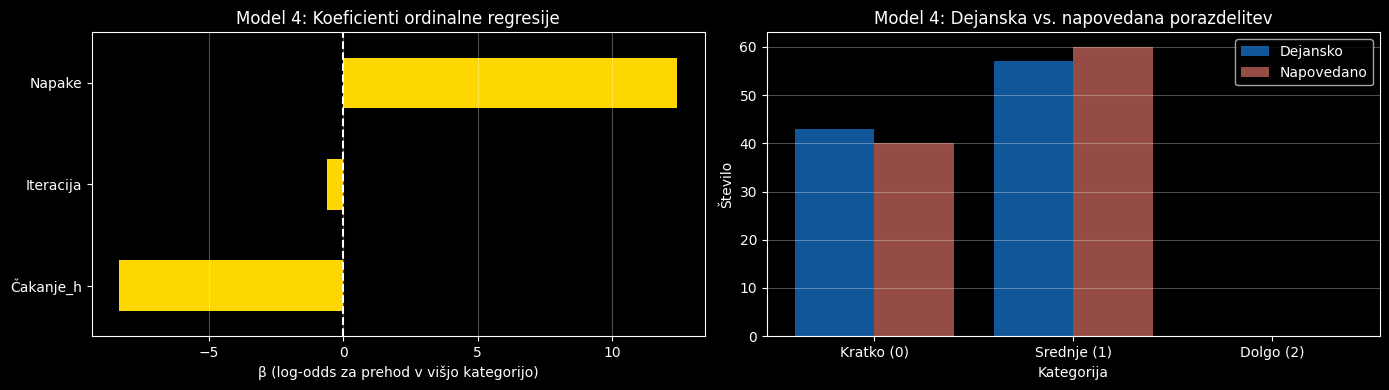


GRAF 1: Koeficienti ordinalne regresije
- Negativen koeficient (Čakanje_h, Iteracija) pomeni manjšo verjetnost prehoda v višjo kategorijo trajanja.
- Pozitiven koeficient (Napake) pomeni večjo verjetnost daljšega trajanja, vendar NI statistično pomemben (p ≈ 0.996).
Ugotovitve:
- Čakanje_h ima najmočnejši in statistično pomemben učinek – več čakanja pomeni krajše trajanje koraka.
- Iteracija prav tako statistično pomembno zmanjšuje možnost prehoda v daljše trajanje.
- Napake v tem modelu nimajo praktičnega vpliva.

GRAF 2: Dejanska vs. napovedana porazdelitev
- Model zelo dobro napove kategoriji 'Kratko' in 'Srednje'.
- Kategorija 'Dolgo' skoraj ni napovedana, ker je tudi v podatkih zelo redka.
Ugotovitve:
- Model dobro zajame glavni vzorec v podatkih.
- Redke kategorije (Dolgo) so težje napovedljive, kar je pričakovano.



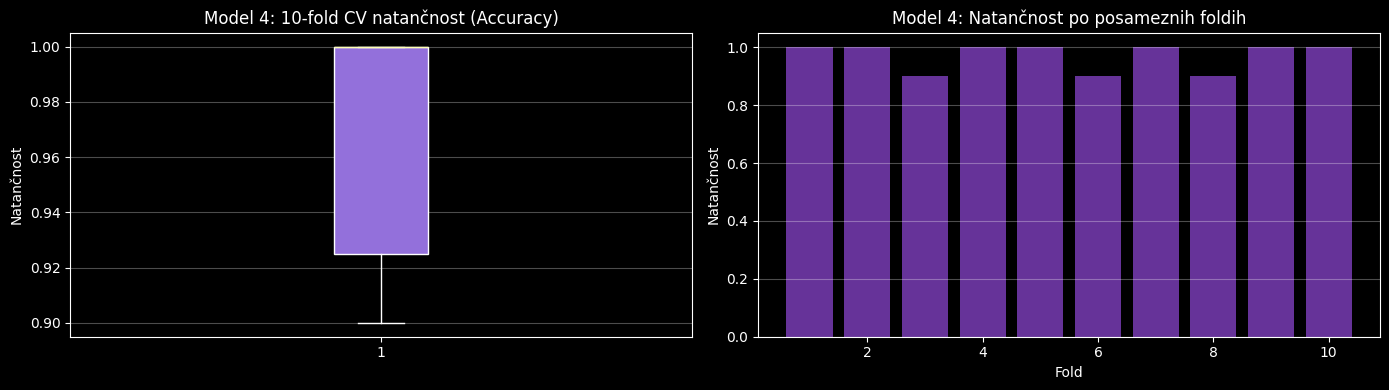


GRAF 3: 10-fold CV natančnost (Accuracy)
- Natančnost je v povprečju okoli 0.97.
- Variabilnost med foldi je majhna (0.90–1.00).
Ugotovitve:
- Model je stabilen in se dobro generalizira.
- Noben fold ne kaže bistvenih odstopanj.

GRAF 4: Natančnost po posameznih foldih
- Večina foldov doseže natančnost 1.00.
- Najnižja izmerjena vrednost je približno 0.90.
Ugotovitve:
- Stabilna učinkovitost potrjuje, da ordinalni model dobro zajame razmerje med spremenljivkami.
- Izjemno visoke vrednosti pričakovano izhajajo iz neravnovesja v kategorijah (npr. malo primerov 'Dolgo').



,Skupina,Spremenljivka,β (koef),SE,p,Interpretacija
0,Napovednik,Čakanje_h,-8.308039,1.572388,1.265940e-07,"Daljše čakanje pomembno zmanjša verjetnost, da..."
1,Napovednik,Napake,12.398122,2231.264580,9.955665e-01,Pozitiven koeficient nakazuje možnost povezave...
2,Napovednik,Iteracija,-0.605125,0.234270,9.793826e-03,Večje število iteracij zmanjšuje verjetnost pr...
3,Prag,0/1,-9.454899,2.363292,6.314664e-05,Predstavlja mejno vrednost med kategorijama Kr...


In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.style.use("dark_background") # dark theme za vse grafe

# Predpostavka: df je DataFrame s potrebnimi stolpci

# 1) Poskrbimo, da imamo Trajanje_kategorija (Kratko / Srednje / Dolgo)
if 'Trajanje_kategorija' not in df.columns:
    def kategoriziraj_trajanje(x):
        # POZOR: Pragi (1.0 in 2.0) so vzeti kot primer
        if x < 1.0:
            return 'Kratko'
        elif x < 2.0:
            return 'Srednje'
        else:
            return 'Dolgo'

    df['Trajanje_kategorija'] = df['Trajanje_h'].apply(kategoriziraj_trajanje)

# 2) Pripravimo podatke za ordinalni model
df_ord = df[['Trajanje_kategorija', 'Čakanje_h', 'Napake', 'Iteracija']].dropna().copy()

# urejeni faktor
cat_type = pd.CategoricalDtype(categories=['Kratko', 'Srednje', 'Dolgo'], ordered=True)
df_ord['Trajanje_kategorija'] = df_ord['Trajanje_kategorija'].astype(cat_type)

# Y kot KODE 0,1,2 (ordinalno)
y4 = df_ord['Trajanje_kategorija'].cat.codes   # 0 = Kratko, 1 = Srednje, 2 = Dolgo
X4 = df_ord[['Čakanje_h', 'Napake', 'Iteracija']]

# 3) Ordinalni model (logit link)
ord_model = OrderedModel(y4, X4, distr='logit')
ord_res = ord_model.fit(method='bfgs')
print(ord_res.summary())

# Koeficienti (β), SE, p
params = ord_res.params
bse = ord_res.bse
pvalues = ord_res.pvalues

print("\nKoeficienti napovednikov:")
for name in X4.columns:
    print(f"{name}: β = {params[name]:.3f}, SE = {bse[name]:.3f}, p = {pvalues[name]:.3f}")


# --- Metrike na celotnem naboru (Train) ---
# ord_res.predict(X4) vrne DataFrame verjetnosti
pred_prob_train = ord_res.predict(X4)

# Kličemo .values, ker je pred_prob_train DataFrame!
pred_class_train = pred_prob_train.values.argmax(axis=1)

accuracy_train = accuracy_score(y4.values, pred_class_train)
print(f"\nTrain natančnost (Accuracy): {accuracy_train:.3f}")


# 4) 10-fold cross-validation za natančnost (accuracy)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
X4_values = X4.values
y_codes = y4.values   # 0,1,2

acc_scores = []

for train_idx, test_idx in kf.split(X4_values):
    X_train, X_test = X4_values[train_idx], X4_values[test_idx]
    y_train, y_test = y_codes[train_idx], y_codes[test_idx]

    mdl = OrderedModel(y_train, X_train, distr='logit')
    res = mdl.fit(method='bfgs', disp=False)

    pred_prob = res.predict(X_test)          # Vrne se kot NumPy array, ker so X_test NumPy array

    # POPRAVEK: Odstranimo .values, ker je pred_prob že NumPy array
    pred_class = pred_prob.argmax(axis=1)    # indeks največje verjetnosti (0,1,2)

    acc = accuracy_score(y_test, pred_class)
    acc_scores.append(acc)


print(f"\n10-fold CV accuracy (ordinalni model): {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")


#### GRAFI #####
coef_ord = params[X4.columns]

categories = ['Kratko (0)', 'Srednje (1)', 'Dolgo (2)']

# ====== 1. PAR GRAFOV ======
fig, ax = plt.subplots(1, 2, figsize=(14,4))

# --- Graf 1: Koeficienti ---
coef_ord.sort_values(ascending=True).plot(
    kind='barh', color="gold", ax=ax[0]
)
ax[0].set_title("Model 4: Koeficienti ordinalne regresije")
ax[0].set_xlabel("β (log-odds za prehod v višjo kategorijo)")
ax[0].axvline(0, color='white', linestyle='--')
ax[0].grid(axis='x', alpha=0.3)

# --- Graf 2: Dejanska vs napovedana porazdelitev ---
ax[1].hist(
    [y4.values, pred_class_train],
    bins=np.arange(4)-0.5,
    label=['Dejansko', 'Napovedano'],
    alpha=0.6,
    color=['dodgerblue', 'salmon']
)
ax[1].set_xticks(np.arange(3))
ax[1].set_xticklabels(categories)
ax[1].set_title("Model 4: Dejanska vs. napovedana porazdelitev")
ax[1].set_xlabel("Kategorija")
ax[1].set_ylabel("Število")
ax[1].legend()
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("""
GRAF 1: Koeficienti ordinalne regresije
- Negativen koeficient (Čakanje_h, Iteracija) pomeni manjšo verjetnost prehoda v višjo kategorijo trajanja.
- Pozitiven koeficient (Napake) pomeni večjo verjetnost daljšega trajanja, vendar NI statistično pomemben (p ≈ 0.996).
Ugotovitve:
- Čakanje_h ima najmočnejši in statistično pomemben učinek – več čakanja pomeni krajše trajanje koraka.
- Iteracija prav tako statistično pomembno zmanjšuje možnost prehoda v daljše trajanje.
- Napake v tem modelu nimajo praktičnega vpliva.

GRAF 2: Dejanska vs. napovedana porazdelitev
- Model zelo dobro napove kategoriji 'Kratko' in 'Srednje'.
- Kategorija 'Dolgo' skoraj ni napovedana, ker je tudi v podatkih zelo redka.
Ugotovitve:
- Model dobro zajame glavni vzorec v podatkih.
- Redke kategorije (Dolgo) so težje napovedljive, kar je pričakovano.
""")

# ====== 2. PAR GRAFOV ======
fig, ax = plt.subplots(1, 2, figsize=(14,4))

# --- Graf 3: Boxplot accuracy ---
ax[0].boxplot(acc_scores, patch_artist=True,
              boxprops=dict(facecolor='mediumpurple'))
ax[0].set_title("Model 4: 10-fold CV natančnost (Accuracy)")
ax[0].set_ylabel("Natančnost")
ax[0].grid(axis='y', alpha=0.3)

# --- Graf 4: Accuracy po foldih ---
ax[1].bar(np.arange(1, 11), acc_scores, color="rebeccapurple")
ax[1].set_title("Model 4: Natančnost po posameznih foldih")
ax[1].set_xlabel("Fold")
ax[1].set_ylabel("Natančnost")
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("""
GRAF 3: 10-fold CV natančnost (Accuracy)
- Natančnost je v povprečju okoli 0.97.
- Variabilnost med foldi je majhna (0.90–1.00).
Ugotovitve:
- Model je stabilen in se dobro generalizira.
- Noben fold ne kaže bistvenih odstopanj.

GRAF 4: Natančnost po posameznih foldih
- Večina foldov doseže natančnost 1.00.
- Najnižja izmerjena vrednost je približno 0.90.
Ugotovitve:
- Stabilna učinkovitost potrjuje, da ordinalni model dobro zajame razmerje med spremenljivkami.
- Izjemno visoke vrednosti pričakovano izhajajo iz neravnovesja v kategorijah (npr. malo primerov 'Dolgo').
""")


#### TABELA #####
# --- 1) Pobere vse parametre ---
all_params = params.index.tolist()

# --- 2) Ločimo napovednike in pragove ---
predictors = [name for name in all_params if "0/1" not in name]  # pravi napovedniki
thresholds = [name for name in all_params if "0/1" in name]      # prag 0/1

# --- 3) Interpretacije po istem vrstnem redu kot bo v tabeli ---
interpretacije_4 = []

for name in predictors + thresholds:

    if name == "Čakanje_h":
        interpretacije_4.append(
            "Daljše čakanje pomembno zmanjša verjetnost, da bo korak prešel v višjo kategorijo trajanja. Negativen koeficient kaže na večjo verjetnost krajšega trajanja."
        )

    elif name == "Napake":
        interpretacije_4.append(
            "Pozitiven koeficient nakazuje možnost povezave z daljšim trajanjem, vendar učinek ni statistično značilen, zato ga model ne potrjuje."
        )

    elif name == "Iteracija":
        interpretacije_4.append(
            "Večje število iteracij zmanjšuje verjetnost prehoda v daljšo kategorijo trajanja. Negativen koeficient kaže na bolj stabilen in krajši proces."
        )

    elif name == "0/1":
        interpretacije_4.append(
            "Predstavlja mejno vrednost med kategorijama Kratko in Srednje. Gre za interni prag modela, ne za napovednik."
        )

    else:
        interpretacije_4.append("")

# --- 4) Skupina (Napovednik ali Prag) ---
groups = (
    ["Napovednik"] * len(predictors)
    + ["Prag"] * len(thresholds)
)

# --- 5) Končna tabela ---
table_model4 = pd.DataFrame({
    "Skupina": groups,
    "Spremenljivka": predictors + thresholds,
    "β (koef)": params[predictors + thresholds].values,
    "SE": bse[predictors + thresholds].values,
    "p": pvalues[predictors + thresholds].values,
    "Interpretacija": interpretacije_4
})

table_model4

Model ordinalne regresije, ki napoveduje kategorijo trajanja koraka (Kratko → Srednje → Dolgo), je pokazal zelo dobro prileganje podatkom. Celotni model je statistično značilen (AIC = 43.44, Log-Likelihood = –17.72), kar potrjuje, da vključene spremenljivke izboljšajo napovedovanje kategorij trajanja.

Najpomembnejši napovednik je Čakanje_h, ki ima močan in statistično značilen negativen učinek (β = –8.308, p < 0.001). To pomeni, da daljše čakanje pomembno zmanjša verjetnost, da bo korak uvrščen v višjo kategorijo trajanja. Podobno tudi Iteracija kaže statistično značilen negativen vpliv (β = –0.605, p = 0.010), kar nakazuje, da večje število ponovitev zmanjša možnost daljšega trajanja koraka.

Spremenljivka Napake sicer kaže pozitiven koeficient, a njen učinek ni statistično značilen (p = 0.996), zato model ne potrjuje vpliva napak na kategorijo trajanja.

Model dosega visoko train natančnost 0.970, kar pomeni, da pravilno razvrsti skoraj vsa opazovanja. Tudi 10-fold cross-validation potrjuje dobro generalizacijo (natančnost 0.970 ± 0.046), kar kaže na stabilnost modela med različnimi vzorci podatkov.

Skupno gledano model zelo učinkovito napoveduje kategorijo trajanja, pri čemer sta najmočnejša napovednika čakanje in iteracije, medtem ko napake v tem primeru ne prispevajo pomembnega dodatnega pojasnila.

## ZAKLJUČEK

V analizi sem uporabila štiri statistične modele, s katerimi sem želela razumeti dejavnike, ki vplivajo na čakanje, trajanje procesa in pojav napak. Vsak model je bil izbran glede na vrsto vprašanja, na katerega odgovarja. Rezultati skupaj pokažejo zelo konsistentno sliko celotnega procesa.

### Model 1 – Enostavna linearna regresija (Čakanje ~ Trajanje)

Prvi model je analiziral samo odnos med trajanjem koraka in čakanjem. Ugotovitve kažejo, da se daljše trajanje korakov povezuje z manj čakanja (negativen koeficient), model pa pojasni približno 39 % variance čakanja.
To pomeni, da trajanje pomembno vpliva na čakanje, vendar obstajajo še drugi dejavniki, ki jih model 1 ne zajame.

### Model 2 – Multilinearna regresija (Čakanje ~ Trajanje + Napake + Iteracija)

Drugi model razširi napoved čakanja z dodatnimi spremenljivkami. Model se izkaže kot zelo močan, saj doseže R² = 0.830, kar pomeni, da pojasni večino variance čakalnega časa.

Najmočnejši vpliv imajo:
* Trajanje_h – daljši koraki zelo zmanjšujejo čakanje (β_std ≈ –0.81)
* Iteracija – več iteracij stabilizira proces in zmanjša čakanje
* Napake – povečanje napak prav tako zmanjša čakanje, kar je lahko posledica specifične dinamike procesa (npr. hitrejše preklapljanje, ko pride do napake)
Model 2 je statistično najmočnejši za napovedovanje čakanja.

### Model 3 – Logistična regresija (Napake: DA/NE)

Cilj tega modela je bil napovedati, ali se bo v koraku pojavila napaka. Vendar podatki kažejo zelo neuravnotežen razred:
* 91 % korakov brez napak
* 9 % korakov z napako

To povzroči kvazi-separacijo, zaradi česar koeficienti niso stabilni ali interpretabilni.
Model sicer doseže visoko accuracy (0.93), vendar to izhaja iz tega, da večinoma napove “0 = brez napake”. Zato logističnega modela v tem kontekstu ne moremo zanesljivo uporabljati za napovedovanje napak.

### Model 4 – Ordinalna regresija (Trajanje kategorija: Kratko–Srednje–Dolgo)

Ordinalni model analizira verjetnost, da bo korak uvrščen v višjo kategorijo trajanja. Rezultati kažejo:

* Čakanje_h ima močan in statistično značilen negativen vpliv → več čakanja pomeni nižjo kategorijo trajanja.
* Iteracija prav tako statistično zmanjša verjetnost daljšega trajanja.
* Napake niso statistično pomembne v tem modelu.
Model doseže zelo visoko train accuracy (0.97) in stabilno 10-fold CV accuracy (0.97 ± 0.046), kar pomeni, da kategorije trajanja napoveduje zelo dobro.